# Аналитика в интернет-магазине

<hr style="border: 1px solid #000;"> 

## Описание проекта
<br> Отдел маркетинга интернет-магазина подготовил список гипотез для увеличения выручки. <br>
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты. <br>

<b>Данные для первой части</b>  <br> 
Файл /datasets/hypothesis.csv <br> 
•	Hypothesis — краткое описание гипотезы; <br>
•	Reach — охват пользователей по 10-балльной шкале; <br>
•	Impact — влияние на пользователей по 10-балльной шкале; <br>
•	Confidence — уверенность в гипотезе по 10-балльной шкале; <br>
•	Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

<b>Данные для второй части</b>    <br>
Файл /datasets/orders.csv.   <br>
•	transactionId — идентификатор заказа;  <br>
•	visitorId — идентификатор пользователя, совершившего заказ;  <br>
•	date — дата, когда был совершён заказ;  <br>
•	revenue — выручка заказа;  <br>
•	group — группа A/B-теста, в которую попал заказ.  <br>
 <br>
Файл /datasets/visitors.csv.   <br>
•	date — дата; <br>
•	group — группа A/B-теста; <br>
•	visitors — количество пользователей в указанную дату в указанной группе A/B-теста  <br>

<hr style="border: 1px solid #000;"> 

## Обзор данных

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')  
import datetime as dt
import seaborn as sns

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')

### hypothesis

In [3]:
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


In [4]:
# строки во всю ширину
pd.options.display.max_colwidth = 150

In [5]:
hypothesis.columns = hypothesis.columns.str.lower()
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Просмотрели дф, привели названия столбцов к нижнему регистру. 

### orders

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [7]:
orders = orders.rename(columns={'transactionId':'orderId'})
orders = orders.rename(columns={'visitorId':'userId'})

In [8]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
orderId    1197 non-null int64
userId     1197 non-null int64
date       1197 non-null datetime64[ns]
revenue    1197 non-null int64
group      1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
orders.head()

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


В дф orders внесены следующие изменения: переименовали столбцы с id, изменили тип данных date с object на datetime.

### visitors

In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [11]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')

In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [13]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


В дф visitors также изменили тип данных на datetime.

Данные подготовлены для дальнейшего анализа.

<hr style="border: 1px solid #000;"> 

## Приоритизация гипотез

### ICE

In [14]:
hypothesis['ICE'] = hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 
hypothesis_ice = hypothesis[['hypothesis','ICE']].round(2).sort_values(by='ICE', ascending=False)
hypothesis_ice

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Наиболее перспективные гипотезы по ICE: 8, 0, 7. Это гипотезы с наибольшим параметром Impact.

### RICE

In [15]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] 
hypothesis_rice = hypothesis[['hypothesis','RICE']].sort_values(by='RICE', ascending=False)
hypothesis_rice 

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективная гипотеза по RICE под номером 7. Так получилось, потому что её параметр Reach равен 10, в то время как у других гипотез он меньше. <br> Затем с 50% отставанием - номер 2. Третье место делят гипотезы 0 и 6, но у них показатель почти в 3 раза ниже.

### Сравнение

In [16]:
#ice_rice = hypothesis_ice.merge(hypothesis_rice, on='hypothesis').sort_values(by='ICE', ascending=False)
#ice_rice

При применении RICE вместо ICE параметр reach сильно меняет приоритетность. <br>
По методу ICE на первом месте стоит гипотеза "акция со скидкой в день рождения". Влияние на пользователя у нее большое (impact 10), но охват намного меньше, чем у других гипотез для увеличения выручки. Она затронет меньше пользователей. Поэтому этой гипотезы нет в топе при применении RICE, так как параметр reach у нее равен 1. <br> Подобная картина с гипотезами о собственной службе доставки и странице отзывов. <br><br>
По методу RICE параметр reach у гипотезы 7 о добавлении формы подписки на все основные страницы оценен на максимальный балл 10, что дало ей первое место. Гипотеза 2 о добавлении блока рекомендаций товаров также в топе из-за высокого показателя reach = 8. <br><br>

Без изменений в рейтинге остались две гипотезы: показ баннеров с актуальными акциями и распродажами на главную страницу и изменение цвета фона главной страницы.

Топ5 получился одинаковым.

Я бы выбрала фреймворк RICE. Топ-5 гипотез получился одинаковым (0,2,6,7,8), но параметр Reach очень важен, ведь он показывает количество пользователей, которых затронет изменение. Поэтому можно выделить 7 гипотезу с максимальным Reach 10 - 'добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок'.


<hr style="border: 1px solid #000;"> 

## Анализ A/B-теста

### Кумулятивная выручка по группам

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами: <br>
•	date — дата; <br>
•	group — группа A/B-теста (A или B); <br>
•	orders — кумулятивное количество заказов на указанную дату в указанной группе; <br>
•	buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе; <br>
•	revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек); <br>
•	visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [17]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 
datesGroups.head()

,date,group
0,2019-08-15,B
2,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


In [18]:
# соберём агрегированные кумулятивные по дням данные о заказах 

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], 
                                                                     orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 
      'orderId' : pd.Series.nunique, 
      'userId' : pd.Series.nunique, 
      'revenue' : 'sum'}), axis=1).sort_values(by=['date','group']) 

ordersAggregated.head()

,date,group,orderId,userId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [19]:
# аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина:
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],
                                                                         visitors['group'] == x['group'])]
                                       .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(
                                        by=['date','group']) 

visitorsAggregated.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [20]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [21]:
# построим графики кумулятивной выручки по дням и группам A/B-тестирования 

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueA.head(5)

,date,revenue,orders
0,2019-08-01,148579,24
2,2019-08-02,242401,44
4,2019-08-03,354874,68
6,2019-08-04,425699,84
8,2019-08-05,549917,109


In [22]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
cumulativeRevenueB.head(5)

,date,revenue,orders
1,2019-08-01,101217,21
3,2019-08-02,266748,45
5,2019-08-03,380996,61
7,2019-08-04,489567,78
9,2019-08-05,581995,101


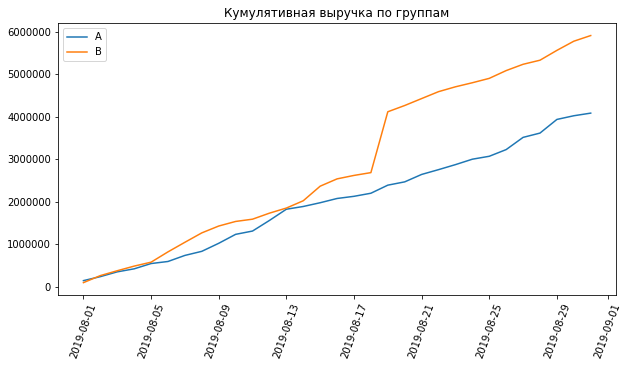

In [23]:
# Строим график выручки группы А
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B 
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.legend()
plt.xticks(rotation=70)
plt.show()

Выручка одинаково увеличивается в начале, почти равномерно увеличивается до середины теста. Затем в середине теста группа B вырывается вперёд и лидирует весь остаток теста с большим отрывом. Это может говорить об увеличении числа заказов, либо о появлении очень дорогих заказов. 

### Кумулятивный средний чек по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов

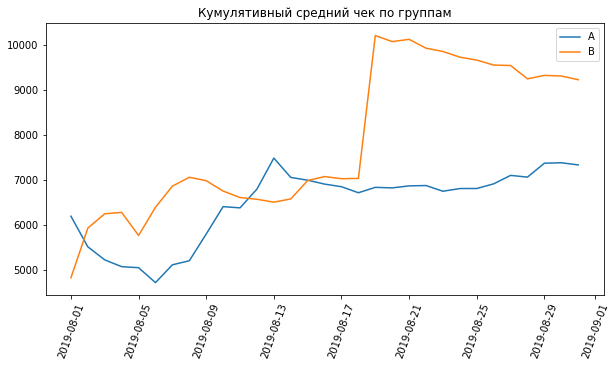

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.legend() 
plt.xticks(rotation=70)
plt.show()

Кумулятивное значение среднего чека по сегментам колеблется, чеки А и B сильно  разнятся. После экватора теста резко увеличивается чек группы B - попали заказы на большие суммы. Нужно провести дополнительный анализ выбросов, которые искажают результаты. К концу теста чек обеих групп устанавливается.

### Относительное изменение кум. среднего чека гр. B к гр. A

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline()  

In [25]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', 
                                                   right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeRevenue.head(5)

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,148579,24,101217,21
1,2019-08-02,242401,44,266748,45
2,2019-08-03,354874,68,380996,61
3,2019-08-04,425699,84,489567,78
4,2019-08-05,549917,109,581995,101


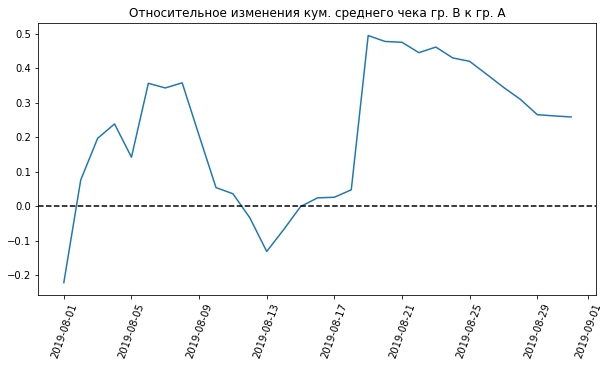

In [26]:
# cтроим отношение средних чеков
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB']) /
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.title('Относительное изменения кум. среднего чека гр. B к гр. A')
plt.xticks(rotation=70)
plt.show()

График различия между сегментами сильно «скачет». 
Результаты теста значительно и резко менялись в несколько периодов, когда были сделаны большие заказы. Средний чек по группе B практически на всем протяжении лежит значительно выше чека группы A. 18-19 августа происходит резкий скачок.

### Кумулятивная конверсия по группам

Аналогично проанализируем график кумулятивной конверсии.  

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

In [28]:
cumulativeDataA.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,24,20,148579,719,0.033380
2,2019-08-02,A,44,38,242401,1338,0.032885
4,2019-08-03,A,68,62,354874,1845,0.036856
6,2019-08-04,A,84,77,425699,2562,0.032787
8,2019-08-05,A,109,100,549917,3318,0.032851


In [29]:
cumulativeDataB.head()

,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,21,20,101217,713,0.029453
3,2019-08-02,B,45,43,266748,1294,0.034776
5,2019-08-03,B,61,59,380996,1803,0.033833
7,2019-08-04,B,78,75,489567,2573,0.030315
9,2019-08-05,B,101,98,581995,3280,0.030793


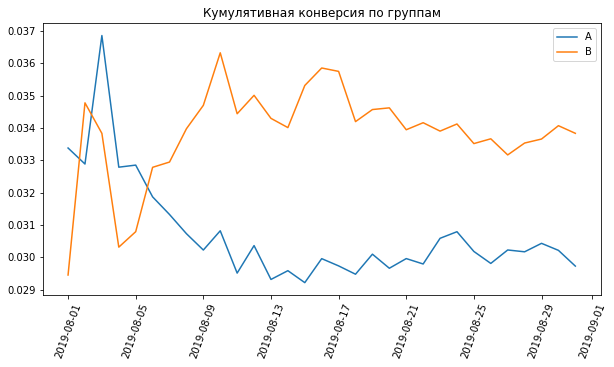

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Кумулятивная конверсия по группам')
plt.legend()
plt.xticks(rotation=70)
plt.show()

График получился почти симметричным. Кумулятивная конверсия группы A практически в течение всего периода значительно ниже конверсии группы B.  Только в начале они демонстрируют схожую динамику и затем в одной точке конверсия A резко возрастает, а B пикирует вниз.

### Относительное изменение кум. конверсии гр. B к гр. A

In [31]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
mergedCumulativeConversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


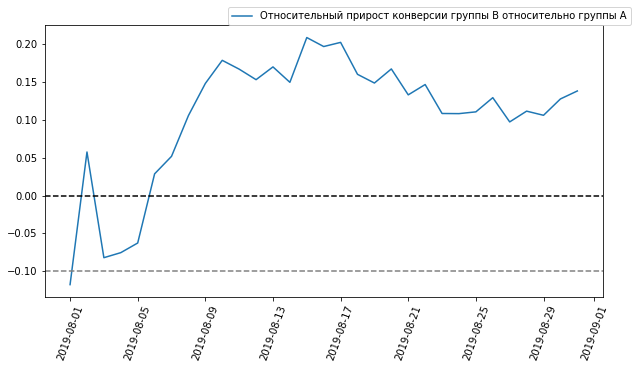

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(mergedCumulativeConversions['date'], 
         mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, 
         label = "Относительный прирост конверсии группы B относительно группы A"
        )
plt.legend()
#plt.title('Относительный прирост конверсии гр. B относительно гр. A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc='lower right', borderaxespad=0.)
plt.xticks(rotation=70)
plt.show()

В начале теста группа B проигрывала группе A, но затем со 2й попытки вырвалась вперёд и продолжала лидировать весь остаток теста. В конце теста зафиксировалась на около прироста в 10-14% относительно группы A.

### Количество заказов по пользователям

In [33]:
ordersByUsers = (orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('userId', as_index=False)
    .agg({'orderId': pd.Series.nunique}))
ordersByUsers.columns = ['userId', 'orders'] 
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 5, 8, 9 и 11 заказов, что намного больше, чем обычный пользователь за неделю. «Обычный» пользователь совершает не больше двух заказов за короткий срок.

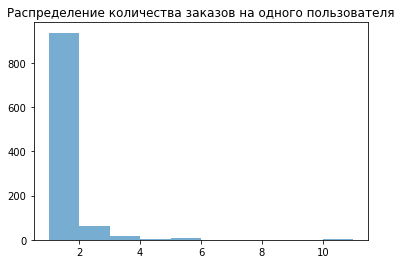

In [34]:
# гистограмма распределения количества заказов на одного пользователя
plt.hist(ordersByUsers['orders'], alpha = 0.6) 
plt.title('Распределение количества заказов на одного пользователя')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2 заказами тоже значительна, с 4 и 6 заказами доля малая. Построим точечную диаграмму числа заказов на одного пользователя.

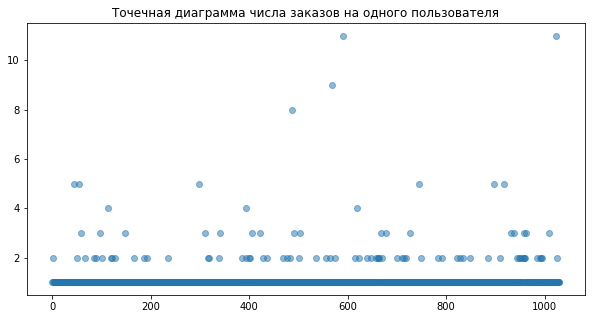

In [35]:
fig, ax = plt.subplots(figsize=(10, 5))
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders'], alpha = 0.5) 
 
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()  

Много пользователей с 2 заказами, поменьше с 3-5. Больше 5 заказов делают очень мало клиентов.

Посчитаем 95 и 99 перцентили количества заказов на одного пользователя

In [36]:
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 2., 4.])

10% пользователей заказывали более одного раза. <br>
Не более 5% пользователей делали больше двух заказов. <br>
И не более 1% пользователей — больше четырёх заказов.

### Стоимость заказов по пользователям

In [37]:
orders 

,orderId,userId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


Среди первых и последних 5 строк цены заказов находятся в диапазоне от 400 до 10550 рублей. Кроме одного — заказ с orderId 1196 составил целых 202 740 рубля!

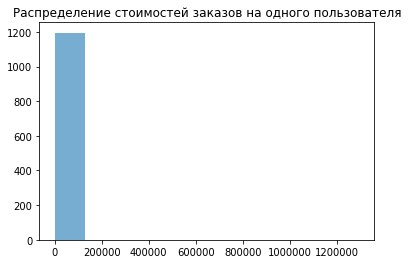

In [38]:
# гистограмма распределения стоимостей заказов
plt.hist(orders['revenue'], alpha = 0.6) 
plt.title('Распределение стоимостей заказов на одного пользователя')
plt.show() 

Большинство заказов на небольшую сумму. Распределение не нормальное, посмотрим точечную диаграммму.

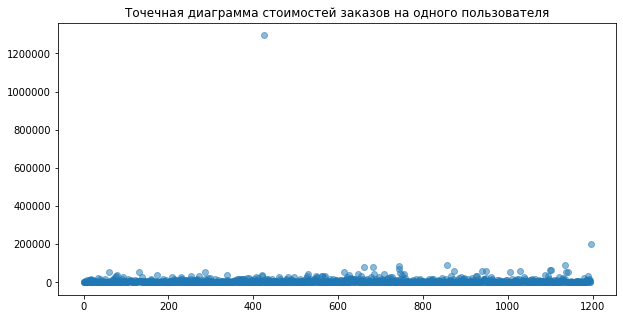

In [39]:
fig, ax = plt.subplots(figsize=(10, 5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'], alpha = 0.5) 
plt.title('Точечная диаграмма стоимостей заказов на одного пользователя')
plt.show() 

Сумма заказа в большинстве своем не превышает 10000 рублей. Есть выбросы 1,3 млн.

Нужно отсеять от 1% до 5% наблюдений с крайними значениями. Определим 90, 95 и 99 перцентили среднего чека в выборке:

In [40]:
np.percentile(orders['revenue'], [90, 95, 99])

array([18168. , 28000. , 58233.2])

Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233 рублей.

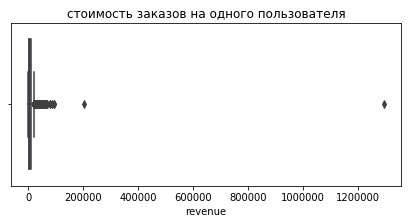

In [41]:
plt.figure(figsize=(7,3))
sns.boxplot(data=orders, x='revenue') 
plt.title('стоимость заказов на одного пользователя')
plt.show()

Видим выбросы, приближаем боксплот

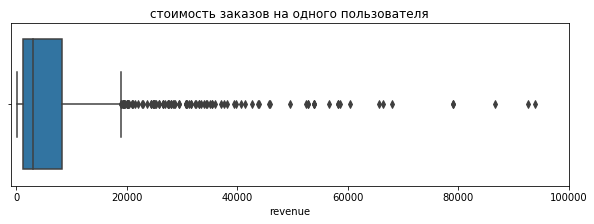

In [42]:
plt.figure(figsize=(10,3))
sns.boxplot(data=orders, x='revenue')
plt.xlim(-1000, 100000)
plt.title('стоимость заказов на одного пользователя')
plt.show()

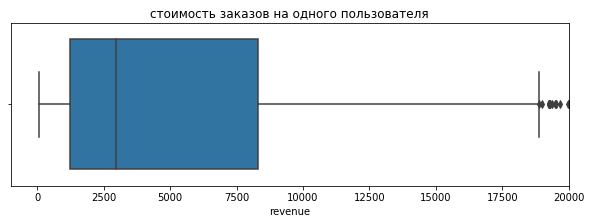

In [43]:
plt.figure(figsize=(10,3))
sns.boxplot(data=orders, x='revenue')
plt.xlim(-1000, 20000)
plt.title('стоимость заказов на одного пользователя')
plt.show()

Медиана стоимости заказа около 3000. 
В среднем от 1250 до 8000 (межквартильный интервал). Размах от 0 до 19000.  

In [44]:
orders['revenue'].median()

2978.0

### Стат. значимость различий в конверсии между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Посмотрим устройство дф data.

In [45]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']


In [46]:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}), axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [47]:
ordersADaily = (orders[orders['group'] == 'A'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'}))

ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

In [48]:
ordersBDaily = (orders[orders['group'] == 'B'][['date', 'orderId', 'userId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'orderId': pd.Series.nunique, 'revenue': 'sum'}))

ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}), axis=1).sort_values(by=['date'])

ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

In [49]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


названия столбцов данных: <br>
•	date — дата;  <br>
•	ordersPerDateA — количество заказов в выбранную дату в группе A;<br>
•	revenuePerDateA — суммарная выручка в выбранную дату в группе A;<br>
•	ordersPerDateB — количество заказов в выбранную дату в группе B;<br>
•	revenuePerDateB — суммарная выручка в выбранную дату в группе B;<br>
•	ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;<br>
•	revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;<br>
•	ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;<br>
•	revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;<br>
•	visitorsPerDateA — количество пользователей в выбранную дату в группе A;<br>
•	visitorsPerDateB — количество пользователей в выбранную дату в группе B;<br>
•	visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;<br>
•	visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.<br>


Посчитаем статистическую значимость различия в конверсии между группами.
Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [50]:
ordersByUsersA = (orders[orders['group'] == 'A'].groupby('userId', as_index=False).agg(
    {'orderId': pd.Series.nunique}))
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (orders[orders['group'] == 'B'].groupby('userId', as_index=False).agg(
    {'orderId': pd.Series.nunique}))
ordersByUsersB.columns = ['userId', 'orders'] 

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. <br> Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.<br>
  <br>
Напомним, что в sampleA сохранили выборку, где число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов определённого пользователя, в том числе ноль.  <br> Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). <br> Аналогично выведем относительный прирост конверсии группы B

In [51]:
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.008
0.138


наши гипотезы: <br> 
H0: По сырым данным конверсии в группах не имеют статистически значимых различий  <br>
H1: По сырым данным конверсии в группах присутствуют статистически значимые различия

P-value меньше 0.05, значит нулевую гипотезу отвергаем. <b> В конверсии </b> между группами есть статистически значимые различия. Относительный прирост конверсии группы B к конверсии группы A равен 13.8%, что означает лидерство группы B.

In [52]:
alpha = 0.05
results = st.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')
print('p-value: {0:.3f}'.format(results[1]))

if results[1] < alpha:
    print('По сырым данным конверсии в группах присутствуют статистически значимые различия')    
else: print('По сырым данным конверсии в группах не имеют статистически значимых различий')
    
print("Относительное изменение: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
По сырым данным конверсии в группах присутствуют статистически значимые различия
Относительное изменение: 0.138


Чтобы рассчитать статистическую значимость различий <b> в среднем чеке </b> между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов. найдём относительные различия в среднем чеке между группами.

In [53]:
print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))

print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.365
0.259


наши гипотезы: <br>  
H0: Средние чеки по сырым данным не имеют статистически значимых различий  <br>
H1: По сырым данным есть статистически значимые различия между средними чеками групп  

P-value значительно больше 0.05 - принимаем нулевую гипотезу.  <b>В среднем чеке </b> нет значимых различий. Средний чек группы B выше среднего чека группы A.

---

<div class="alert alert-block alert-danger">
    

**Комментарий ревьюера v2**

p_value рассчитан не совсем корректно. Смотри комментарий выше.
</div>

---

In [54]:
chek_sampleA = orders.query('group == "A"')['revenue']
chek_sampleB = orders.query('group == "B"')['revenue']

In [55]:
alpha = 0.05

results2 = st.mannwhitneyu(chek_sampleA, chek_sampleB, alternative = 'two-sided')

print('p-value: {0:.3f}'.format(results2[1]))

if results[1] < alpha:
    print('По сырым данным есть статистически значимые различия между средними чеками групп')    
else: print('Средние чеки по сырым данным не имеют статистически значимых различий')
    
print("Относительное изменение: {0:.3f}".format(chek_sampleB.mean() / chek_sampleA.mean() - 1))

p-value: 0.729
По сырым данным есть статистически значимые различия между средними чеками групп
Относительное изменение: 0.259


### Стат. значимость различий в конверсии между группами по очищенным данным

95-й и 99-й перцентили средних чеков равны 28 000 и 58 233 руб. <br> 
95-й и 99-й перцентили количества заказов равны 2 и 4 заказа на пользователя.

Примем за аномальных пользователей тех, кто совершил больше 3 заказов или совершил заказ дороже 30 000 рублей. <br>
Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 20 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.
Узнаем, сколько всего аномальных пользователей методом shape().

In [56]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['userId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape) 

1099    148427295
18      199603092
928     204675465
23      237748145
37      249864742
Name: userId, dtype: int64
(74,)


Всего 74
аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста

In [57]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
) 

Применим статистический критерий Манна-Уитни 

In [58]:
print('{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

0.007
0.173


наши гипотезы: <br> 
H0: По очищенным данным конверсии в группах не имеют статистически значимых различий  <br>
H1: По очищенным данным между конверсиями групп присутствуют статистически значимые различия

P-value значительно меньше 0.05. По очищенным данным тоже отвергаем нулевую гипотезу - различия в конверсии есть. Результаты по конверсии практически не изменились (по сырым 0.008, 0.138). Группа А отстает примерно 15%. Конверсия увеличилась. Далее смотрим средний чек

In [59]:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['userId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['userId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

0.369
-0.020


наши гипотезы: <br>  
H0: Средние чеки по очищенным данным не имеют статистически значимых различий   <br>
H1: По очищенным данным есть статистически значимые различия между средними чеками групп  
 

P-value значительно больше 0.05 - принимаем нулевую гипотезу. В среднем чеке  по очищенным данным тоже нет значимых различий.  <br>
По сырым: 0.365 и 0.259. P-value уменьшился, Сегмент A теперь стал лучше сегмента B. Прирост у B отсутствует.

In [60]:
alpha = 0.05

results3= st.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')
 
print('p-value: {0:.3f}'.format(results3[1]))

if results[1] < alpha:
    print('По очищенным данным между конверсиями групп присутствуют статистически значимые различия')    
else: print('По очищенным данным конверсии в группах не имеют статистически значимых различий')    

    
print("Относительное изменение: {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

p-value: 0.013
По очищенным данным между конверсиями групп присутствуют статистически значимые различия
Относительное изменение: 0.173


In [61]:
chek2_sampleA = orders[(orders['group'] == "A")&(np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue']
chek2_sampleB = orders[(orders['group'] == "B")&(np.logical_not(orders['userId'].isin(abnormalUsers)))]['revenue']

In [62]:
alpha = 0.05

results4 = st.mannwhitneyu(chek2_sampleA, chek2_sampleB, alternative = 'two-sided')
 
print('p-value: {0:.3f}'.format(results4[1]))

if results[1] < alpha:
    print('По очищенным данным есть статистически значимые различия между средними чеками групп')    
else: print('Средние чеки по очищенным данным не имеют статистически значимых различий')
    
print("Относительное изменение: {0:.3f}".format(chek2_sampleB.mean() / chek2_sampleA.mean() - 1))

p-value: 0.738
По очищенным данным есть статистически значимые различия между средними чеками групп
Относительное изменение: -0.020


## Выводы

В начале работы мы подготовили таблицы, изменили тип данных. Далее приоритизировали гипотезы двумя способами - ICE & RICE. Первая пятерка гипотез в рейтинге приоритета у них одинаковая, но порядок меняется из-за параметра Reach. Выбираем RICE как основной.

Далее собрали кумулятивные данные, графики кумулятивной выручки и среднего чека. Выявили выбросы в данных. График относительного различия для среднего чека показал, что средний чек по группе B лежит значительно выше чека группы A. Изучили график кумулятивной конверсии:  конверсия группы A практически в течение всего периода значительно ниже конверсии группы B. 
Относительный прирост конверсии группы B относительно группы A к концу теста соствил 10-14%.

Далее мы рассмотрели выбросы: для среднего чека - сумма заказа, для конверсии - количество заказов на пользователя. Принялм за аномальных пользователей тех, кто совершил больше 3 заказов или совершил заказ дороже 30 000 рублей (95 персентиль).

Затем проверили значимость различий в конверсии и среднем чеке. <br> В конверсии между группами есть статистически значимые различия. Результаты по сырым и очищенным данным практически одинаковы. Прирост конверсии группы B к конверсии группы A около 14-15%.

В среднем чеке между группами нет статистически значимых различий в конверсии между группами. Относительный прирост конверсии группы B к конверсии группы A уменьшился.

График различия конверсии между группами сообщает, что результаты группы B лучше группы A: имеют тенденцию к росту. <br>
График различия среднего чека колеблется, видно аномалии. Результаты группы B имеют тенденцию к снижению. 

Исходя из обнаруженных фактов, тест можно остановить и считать успешно проведенным. Фиксируем прирост конверсии группы B.  

поищем пересечение групп.  Получилось 58 пользователей. По-моему, их мало и можно их не удалять, оставить как есть.

In [63]:
visitors_A = orders[orders['group']=='A']['userId']
visitors_B = orders[orders['group']=='B']['userId']

In [64]:
# пользователи в разных группах
visitors_AB = orders.loc[orders['userId'].isin(visitors_A) & orders['userId'].isin(visitors_B),'userId'].unique()

In [65]:
visitors_AB.shape[0]

58